# 필요한 라이브러리 import 및 분류 모델로 쓰일 MLSTM-FCN 모델 정의

In [ ]:
import keras
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout
from keras import backend as K
import tensorflow as tf
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

#MLSTM Model
def generate_model():
    ip = Input(shape=(9,24))

    x = Masking()(ip)
    x = LSTM(8)(x)
    x = Dropout(0.8)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)

    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(3, activation='softmax')(x)

    model = Model(ip, out)
    #model.summary()

    # add load model code here to fine-tune

    return model

def squeeze_excite_block(input):
    ''' Create a squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    #filters = input._keras_shape[-1] # channel_axis = -1 for TF
    filters = input.shape[-1]

    se = GlobalAveragePooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = multiply([input, se])
    return se

#model compile metrics f1_score 함수 정의
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# 정상 고장 분류 모델링

In [ ]:
#정상(normal),고장(error_p:상개방,error_i:interturn) 분류
def clf_nor_err_modeling(file_path): #file_path : 정상 데이터, 고장 데이터가 각각 다른 sheet이고 하나의 excel로 묶여있는 파일의 경로

  print('Data Loading...') #데이터 준비
  cols=['Ia', 'Ib', 'Ic', 'Idc', 'RPM', 'Torque', 'Ia_RMS', 'Ib_RMS', 'Ic_RMS']
  normal=pd.read_excel(file_path,sheet_name=0,header=1,usecols=cols)
  error_p=pd.read_excel(file_path,sheet_name=1,header=1,usecols=cols)
  error_i=pd.read_excel(file_path,sheet_name=2,header=1,usecols=cols)
  normal.dropna(how='any',inplace=True)
  error_p.dropna(how='any',inplace=True)
  error_i.dropna(how='any',inplace=True)

  print('Data Preprocessing...') #데이터 전처리
  #24크기으windows로 slicing
  normal = tf.data.Dataset.from_tensor_slices(normal)
  normal = normal.window(24,shift=1,drop_remainder=True)
  list_n = []
  for d in normal:
      i1 = list(d.as_numpy_iterator())
      list_n.append(i1)

  normal = np.array(list_n)

  error_p = tf.data.Dataset.from_tensor_slices(error_p)
  error_p = error_p.window(24,shift=1,drop_remainder=True)
  list_f = []
  for d in error_p:
      i3 = list(d.as_numpy_iterator())
      list_f.append(i3)

  error_p = np.array(list_f)

  error_i = tf.data.Dataset.from_tensor_slices(error_i)
  error_i = error_i.window(24,shift=1,drop_remainder=True)
  list_f = []
  for d in error_i:
      i3 = list(d.as_numpy_iterator())
      list_f.append(i3)

  error_i = np.array(list_f)

  dataset=np.concatenate([normal,error_p,error_i])
  labels=[0]*len(normal)+[1]*len(error_p)+[2]*len(error_i)
  labels=np.array(labels)
  idx=np.random.permutation(len(dataset))
  dataset=dataset[idx]
  labels=labels[idx]

  X_train,X_test,y_train,y_test=train_test_split(dataset,labels,stratify=labels,random_state=42,shuffle=True,test_size=0.2)

  scaler=StandardScaler()
  X_train=scaler.fit_transform(X_train.reshape(-1,9)).reshape(-1,24,9)
  X_test=scaler.transform(X_test.reshape(-1,9)).reshape(-1,24,9)

  data=[]
  for i in range(len(X_train)):
    data.append(X_train[i].T)
  X_train=np.array(data)

  data=[]
  for i in range(len(X_test)):
    data.append(X_test[i].T)
  X_test=np.array(data)

  y_train=to_categorical(y_train)
  y_test=to_categorical(y_test)

  print('Data Modeling...') #모델링 시작

  model=generate_model()

  adam = Adam(lr=1e-3)
  chk = ModelCheckpoint('best_model.pkl', monitor='val_loss', save_best_only=True, mode='auto', verbose=False)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy',get_f1])
  history = model.fit(X_train, y_train, epochs=100, batch_size=128, callbacks=[chk],validation_data=(X_test,y_test))

  preds_prob=model.predict(X_test)
  test_preds = [np.argmax(i) for i in preds_prob]
  y_test_res = [np.argmax(i) for i in y_test]
  cf=confusion_matrix(y_test_res,test_preds)
  f1=f1_score(test_preds,y_test_res,average='macro')
  test_accuracy = 100*np.sum(np.array(test_preds) == y_test_res)/len(test_preds)
  #test set에 대한 결과
  print(iter)
  print('Accuracy of the model on test set:', test_accuracy)
  print('f1 score of the model on test set:',f1)
  print(cf)
  print('\n')

  #학습 과정 plot
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.ylim(ymin=0,ymax=1.05)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()

  
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()

  plt.plot(history.history['get_f1'])
  plt.plot(history.history['val_get_f1'])
  plt.ylim(ymin=0,ymax=1.05)
  plt.title('model f1')
  plt.ylabel('f1')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()

  return model,scaler #모델링에 사용되었던 스케일러와 모델 return

# 정상, 전조증상, 고장 분류 모델링

In [ ]:
#정상(normal), 전조증상(portent),고장(error) 분류 모델링
def clf_por_err_modeling(ori_path,syn_path,error_type): #ori_path : file_path와 같음 / syn_path : 기존 학습시킬 데이터 중 전조증상 부분 데이터양이 부족하여 TimeGAN을 이용하여 미리 증강시킨 추가 데이터가 담긴 폴더 경로

  print('Data Loading...')

  cols=['Ia', 'Ib', 'Ic', 'Idc', 'RPM', 'Torque', 'Ia_RMS', 'Ib_RMS', 'Ic_RMS']
  normal=pd.read_excel(ori_path,sheet_name=0,header=1,usecols=cols)
  normal.dropna(how='any',inplace=True)

  if error_type=='p':
    error=pd.read_excel(ori_path,sheet_name=1,header=1,usecols=cols)

  else:
    error=pd.read_excel(ori_path,sheet_name=2,header=1,usecols=cols)

  syn_por1=np.load(syn_path+'eerror_{}_portent_generated_data_inverse1.npy'.format(error_type))
  syn_por2=np.load(syn_path+'eerror_{}_portent_generated_data_inverse2.npy'.format(error_type))
  syn_por3=np.load(syn_path+'eerror_{}_portent_generated_data_inverse3.npy'.format(error_type))
  syn_por4=np.load(syn_path+'eerror_{}_portent_generated_data_inverse4.npy'.format(error_type))
  
  error.dropna(how='any',inplace=True)
  portent=error.iloc[:160,:]
  error=error.iloc[160:,:]

  print('Data Preprocessing...')

  normal = tf.data.Dataset.from_tensor_slices(normal)
  normal = normal.window(24,shift=1,drop_remainder=True)
  list_n = []
  for d in normal:
      i1 = list(d.as_numpy_iterator())
      list_n.append(i1)
  normal = np.array(list_n)

  error = tf.data.Dataset.from_tensor_slices(error)
  error = error.window(24,shift=1,drop_remainder=True)
  list_f = []
  for d in error:
      i3 = list(d.as_numpy_iterator())
      list_f.append(i3)
  error = np.array(list_f)

  portent = tf.data.Dataset.from_tensor_slices(portent)
  portent = portent.window(24,shift=1,drop_remainder=True)
  list_p = []
  for d in portent:
      i2 = list(d.as_numpy_iterator())
      list_p.append(i2)
  portent = np.array(list_p)

  X_train_normal,X_test_normal=train_test_split(normal,random_state=42,shuffle=True,test_size=0.2)
  X_train_error,X_test_error=train_test_split(error,random_state=42,shuffle=True,test_size=0.2)
  X_train_por,X_test_por=train_test_split(portent,random_state=42,shuffle=True,test_size=0.2)

  print('X_train_normal shape :',X_train_normal.shape)
  print('X_test_normal shape :',X_test_normal.shape)
  print('X_train_error shape :',X_train_error.shape)
  print('X_test_error shape :',X_test_error.shape)
  print('X_train_portent shape :',X_train_por.shape)
  print('X_test_portetn shape :',X_test_por.shape)

  syn_por=np.concatenate([syn_por1,syn_por2,syn_por3,syn_por4])
  print('syn portetn shape (with TimeGAN) :',syn_por.shape)

  X_train_por=np.concatenate([X_train_por,syn_por])

  X_train=np.concatenate([X_train_normal,X_train_por,X_train_error])
  print('train data shape :',X_train.shape)

  X_test=np.concatenate([X_test_normal,X_test_por,X_test_error])
  y_test=np.array([0]*len(X_test_normal)+[1]*len(X_test_por)+[2]*len(X_test_error))

  idx=np.random.permutation(len(X_train)) #shuffle train data
  X_train=X_train[idx]
  y_train=np.array([0]*len(X_train_normal)+[1]*len(X_train_por)+[2]*len(X_train_error)) #정상 : 0 / 전조증상 : 1 / 고장 : 2 #train set label
  y_train=y_train[idx]

  scaler=StandardScaler()
  X_train=scaler.fit_transform(X_train.reshape(-1,9)).reshape(-1,24,9)
  X_test=scaler.transform(X_test.reshape(-1,9)).reshape(-1,24,9)

  data=[]
  for i in range(len(X_train)):
    data.append(X_train[i].T)
  X_train=np.array(data)

  data=[]
  for i in range(len(X_test)):
    data.append(X_test[i].T)
  X_test=np.array(data)

  y_train=to_categorical(y_train)
  y_test=to_categorical(y_test)

  print('Data Modeling...')

  model=generate_model()

  adam = Adam(lr=1e-3)
  chk = ModelCheckpoint('best_model.pkl', monitor='val_loss', save_best_only=True, mode='auto', verbose=False)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy',get_f1])
  history = model.fit(X_train, y_train, epochs=100, batch_size=128, callbacks=[chk],validation_data=(X_test,y_test))

  preds_prob=model.predict(X_test)
  test_preds = [np.argmax(i) for i in preds_prob]
  y_test_res = [np.argmax(i) for i in y_test]
  cf=confusion_matrix(y_test_res,test_preds)
  f1=f1_score(test_preds,y_test_res,average='macro')
  test_accuracy = 100*np.sum(np.array(test_preds) == y_test_res)/len(test_preds)
  print(iter)
  print('Accuracy of the model on test set:', test_accuracy)
  print('f1 score of the model on test set:',f1)
  print(cf)
  print('\n')

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.ylim(ymin=0,ymax=1.05)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()

  plt.plot(history.history['get_f1'])
  plt.plot(history.history['val_get_f1'])
  plt.ylim(ymin=0,ymax=1.05)
  plt.title('model f1')
  plt.ylabel('f1')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()

  return model,scaler

# 실제 input에 대한 모델 적용 함수

In [ ]:
# 학습된 모델, 스케일러를 가지고 실제 input을 예측

def clf_apply(model,scaler,input,output=None):
  input_ = tf.data.Dataset.from_tensor_slices(input)
  input_ = input_.window(24,shift=1,drop_remainder=True)
  list_input = []
  for d in input_:
      i3 = list(d.as_numpy_iterator())
      list_input.append(i3)
  input_ = np.array(list_input)

  input_=scaler.transform(input_.reshape(-1,9)).reshape(-1,24,9)

  data=[]
  for i in input_:
    data.append(i.T)
  input_=np.array(data)

  probs=model.predict(input_)
    
  if len(input)==len(output): #input에 대한 정답 output이 있는 경우
    labels=output[12:12+len(input_)]
  else:
    labels=None

  return probs,labels #클래스별 분류 확률로 return

# input에 대한 분류 확률을 시각화 및 score 산출

In [ ]:
#sample에 대해 정상,고장p,i로 분류할 확률 중 평균이 가장 높은 것으로
def return_mode1(probs):
  mode=['n','p','i']
  norm_prob=probs[:,0].mean()
  p_prob=probs[:,1].mean()
  i_prob=probs[:,2].mean()
  prob_avg=[norm_prob,p_prob,i_prob]
  return mode[np.argmax(prob_avg)]



#예측 결과를 plotting
'''def plot_nor_err_result(probs,labels=None): #정상 고장 분류 plot
  preds=np.argmax(probs,axis=1)
  plt.figure(figsize=(15,5))
  plt.plot(preds)
  plt.title('predicted Result(normal:0 / phase_open:1 / interturn:2)')
  plt.show()
  plt.figure(figsize=(15,5))
  plt.plot(probs[:,0],'g',label='normal')
  plt.plot(probs[:,1],'purple',label='phase_open')
  plt.plot(probs[:,2],'k',label='interturn')
  plt.title('Probability')
  plt.legend(loc='best')
  plt.show()
  if labels!=None:
    print('Accuracy : {}'.format(np.sum(labels==preds)/len(labels)))'''


#예측확률 결과를 plotting
def plot_por_err_result(probs,labels=None): #정상 전조증상 고장 분류 plot
  preds=np.argmax(probs,axis=1)
  if len(labels)==len(probs):
    plt.figure(figsize=(15,5))
    plt.plot(labels)
    plt.title('Targets')
    plt.show()
  plt.figure(figsize=(15,5))
  plt.plot(preds)
  plt.title('predicted Result')
  plt.show()
  plt.figure(figsize=(15,5))
  plt.plot(probs[:,0],'g',label='normal')
  plt.plot(probs[:,1],'y',label='portent')
  plt.plot(probs[:,2],'r',label='error')
  plt.title('Probability')
  plt.legend(loc='best')
  plt.show()
  if len(labels)==len(preds):
    print('Accuracy : {}'.format(np.sum(labels.values.ravel()==preds)/len(labels)))

# 예시

In [ ]:
import os
norm_path='/content/drive/MyDrive/motor_break/normal/'
p_path='/content/drive/MyDrive/motor_break/error_p/'
i_path='/content/drive/MyDrive/motor_break/error_i/'
norm_aug=os.listdir(norm_path)
p_aug=os.listdir(p_path)
i_aug=os.listdir(i_path)

In [ ]:
## 증강한 데이터 plot을 원하시면 이 코드 돌려보시면 됩니다 !

data = pd.read_csv("plot해보고 싶은 csv")

for col in data.columns:
  plt.title(col)
  data[col].plot(figsize=(15,5))
  plt.show()

Data Loading...
Data Preprocessing...
Data Modeling...
Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9892 - get_f1: 0.9794

37/37 [==============================] - 24s 299ms/step - loss: 0.0418 - accuracy: 0.9892 - get_f1: 0.9794 - val_loss: 0.0267 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 8.4799e-04 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 244ms/step - loss: 8.4799e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 3/100
34/37 [==========================>...] - ETA: 0s - loss: 5.3327e-04 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 272ms/step - loss: 5.2789e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 4/100
37/37 [==============================] - ETA: 0s - loss: 3.6471e-04 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 251ms/step - loss: 3.6471e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 5/100
37/37 [==============================] - ETA: 0s - loss: 3.3168e-04 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 270ms/step - loss: 3.3168e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.1540e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 6/100
36/37 [============================>.] - ETA: 0s - loss: 2.4460e-04 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 13s 363ms/step - loss: 2.4373e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.7993e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 7/100
36/37 [============================>.] - ETA: 0s - loss: 2.0369e-04 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 276ms/step - loss: 2.0190e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.3705e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 8/100
37/37 [==============================] - ETA: 0s - loss: 1.7730e-04 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 252ms/step - loss: 1.7730e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.7707e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 9/100
33/37 [=========================>....] - ETA: 0s - loss: 1.7979e-04 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 282ms/step - loss: 1.7382e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.3766e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 10/100
35/37 [===========================>..] - ETA: 0s - loss: 1.3356e-04 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 236ms/step - loss: 1.3528e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.0227e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 11/100
37/37 [==============================] - ETA: 0s - loss: 1.0992e-04 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 259ms/step - loss: 1.0992e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 8.5407e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 12/100
36/37 [============================>.] - ETA: 0s - loss: 1.1122e-04 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 13s 368ms/step - loss: 1.1090e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.5207e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 13/100
37/37 [==============================] - ETA: 0s - loss: 9.4986e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 13s 369ms/step - loss: 9.4986e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.2237e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 14/100
37/37 [==============================] - ETA: 0s - loss: 8.8146e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 251ms/step - loss: 8.8146e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.4596e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 15/100
36/37 [============================>.] - ETA: 0s - loss: 8.2317e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 11s 307ms/step - loss: 8.2063e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.1394e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 16/100
37/37 [==============================] - ETA: 0s - loss: 7.1464e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 15s 408ms/step - loss: 7.1464e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.2594e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 17/100
37/37 [==============================] - ETA: 0s - loss: 7.9238e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 12s 321ms/step - loss: 7.9238e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.9302e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 18/100
37/37 [==============================] - ETA: 0s - loss: 7.1188e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 14s 379ms/step - loss: 7.1188e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.4203e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 19/100
36/37 [============================>.] - ETA: 0s - loss: 6.1026e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 13s 366ms/step - loss: 6.0787e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.3123e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 20/100
37/37 [==============================] - ETA: 0s - loss: 5.0955e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 13s 354ms/step - loss: 5.0955e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.9602e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 21/100
36/37 [============================>.] - ETA: 0s - loss: 5.1403e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 13s 362ms/step - loss: 5.1326e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.8059e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 22/100
37/37 [==============================] - ETA: 0s - loss: 5.4625e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 13s 365ms/step - loss: 5.4625e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.6218e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 23/100
37/37 [==============================] - ETA: 0s - loss: 4.4828e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 11s 313ms/step - loss: 4.4828e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.3674e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 24/100
37/37 [==============================] - ETA: 0s - loss: 4.7086e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 285ms/step - loss: 4.7086e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.2098e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 25/100
36/37 [============================>.] - ETA: 0s - loss: 3.6854e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 11s 314ms/step - loss: 3.7760e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.0624e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 26/100
36/37 [============================>.] - ETA: 0s - loss: 3.8294e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 11s 298ms/step - loss: 3.8686e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.0040e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 27/100
36/37 [============================>.] - ETA: 0s - loss: 3.6446e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 253ms/step - loss: 3.6446e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.9520e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 28/100
37/37 [==============================] - ETA: 0s - loss: 3.2212e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 289ms/step - loss: 3.2212e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.7711e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 29/100
37/37 [==============================] - ETA: 0s - loss: 3.1401e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 12s 319ms/step - loss: 3.1401e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.5988e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 30/100
36/37 [============================>.] - ETA: 0s - loss: 2.8102e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 272ms/step - loss: 2.8275e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.4699e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 31/100
36/37 [============================>.] - ETA: 0s - loss: 2.5758e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 16s 437ms/step - loss: 2.6070e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.3891e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 32/100
37/37 [==============================] - ETA: 0s - loss: 2.8630e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 15s 413ms/step - loss: 2.8630e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.3334e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 33/100
37/37 [==============================] - ETA: 0s - loss: 2.5929e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 237ms/step - loss: 2.5929e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.2859e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 34/100
37/37 [==============================] - ETA: 0s - loss: 2.1462e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 11s 292ms/step - loss: 2.1462e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.1973e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 35/100
37/37 [==============================] - ETA: 0s - loss: 2.1035e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 249ms/step - loss: 2.1035e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.1439e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 36/100
36/37 [============================>.] - ETA: 0s - loss: 1.9194e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 266ms/step - loss: 1.9064e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.0928e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 37/100
37/37 [==============================] - ETA: 0s - loss: 2.3236e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 267ms/step - loss: 2.3236e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.0247e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 38/100
36/37 [============================>.] - ETA: 0s - loss: 1.9100e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 247ms/step - loss: 1.9047e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 9.8778e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 39/100
36/37 [============================>.] - ETA: 0s - loss: 1.8556e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 8s 235ms/step - loss: 1.8382e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 9.3506e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 40/100
33/37 [=========================>....] - ETA: 0s - loss: 1.8411e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 13s 371ms/step - loss: 1.8209e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 8.7938e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 41/100
35/37 [===========================>..] - ETA: 0s - loss: 1.8074e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 13s 361ms/step - loss: 1.8092e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 8.3229e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 42/100
37/37 [==============================] - ETA: 0s - loss: 1.6374e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 13s 352ms/step - loss: 1.6374e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.9243e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 43/100
36/37 [============================>.] - ETA: 0s - loss: 1.4568e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 12s 323ms/step - loss: 1.4531e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.5810e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 44/100
37/37 [==============================] - ETA: 0s - loss: 1.5684e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 278ms/step - loss: 1.5684e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.2383e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 45/100
33/37 [=========================>....] - ETA: 0s - loss: 1.2024e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 280ms/step - loss: 1.2882e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.0544e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 46/100
36/37 [============================>.] - ETA: 0s - loss: 1.8801e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 249ms/step - loss: 1.8640e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.9962e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 47/100
37/37 [==============================] - ETA: 0s - loss: 1.2553e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 267ms/step - loss: 1.2553e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.4038e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 48/100
35/37 [===========================>..] - ETA: 0s - loss: 1.4357e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 11s 311ms/step - loss: 1.4266e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.0551e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 49/100
35/37 [===========================>..] - ETA: 0s - loss: 1.2205e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 12s 342ms/step - loss: 1.2440e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.7089e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 50/100
34/37 [==========================>...] - ETA: 0s - loss: 1.5464e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 12s 322ms/step - loss: 1.5331e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.4573e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 51/100
37/37 [==============================] - ETA: 0s - loss: 1.4930e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 11s 311ms/step - loss: 1.4930e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.1958e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 52/100
35/37 [===========================>..] - ETA: 0s - loss: 1.1042e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 12s 321ms/step - loss: 1.1752e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.1151e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 53/100
36/37 [============================>.] - ETA: 0s - loss: 1.0498e-05 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 12s 324ms/step - loss: 1.0516e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.8288e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 54/100
37/37 [==============================] - ETA: 0s - loss: 9.9750e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 280ms/step - loss: 9.9750e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.6651e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 55/100
35/37 [===========================>..] - ETA: 0s - loss: 9.2382e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 13s 356ms/step - loss: 9.2414e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.4861e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 56/100
34/37 [==========================>...] - ETA: 0s - loss: 9.8055e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 12s 341ms/step - loss: 9.6450e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.4164e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 57/100
36/37 [============================>.] - ETA: 0s - loss: 9.2862e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 13s 360ms/step - loss: 9.2356e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.3037e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 58/100
37/37 [==============================] - ETA: 0s - loss: 8.4050e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 14s 378ms/step - loss: 8.4050e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.1570e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 59/100
37/37 [==============================] - ETA: 0s - loss: 8.9875e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 13s 351ms/step - loss: 8.9875e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.0431e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 60/100
36/37 [============================>.] - ETA: 0s - loss: 8.6314e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 238ms/step - loss: 8.5421e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.9111e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 61/100
37/37 [==============================] - ETA: 0s - loss: 8.7408e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 263ms/step - loss: 8.7408e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.7061e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 62/100
35/37 [===========================>..] - ETA: 0s - loss: 8.4532e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 251ms/step - loss: 8.3287e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.5881e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 63/100
37/37 [==============================] - ETA: 0s - loss: 8.0731e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 266ms/step - loss: 8.0731e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.3999e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 64/100
37/37 [==============================] - ETA: 0s - loss: 6.8570e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 12s 339ms/step - loss: 6.8570e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.3515e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 65/100
36/37 [============================>.] - ETA: 0s - loss: 9.8629e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 8s 234ms/step - loss: 9.7099e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.2972e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 66/100
36/37 [============================>.] - ETA: 0s - loss: 6.7419e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 16s 431ms/step - loss: 6.7057e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.1242e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 67/100
36/37 [============================>.] - ETA: 0s - loss: 9.1337e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 14s 389ms/step - loss: 9.5128e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.9725e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 68/100
37/37 [==============================] - ETA: 0s - loss: 6.2445e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 15s 422ms/step - loss: 6.2445e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.8604e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 69/100
35/37 [===========================>..] - ETA: 0s - loss: 6.4774e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 250ms/step - loss: 6.5041e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.7822e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 70/100
37/37 [==============================] - ETA: 0s - loss: 6.5306e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 254ms/step - loss: 6.5306e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.6489e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 71/100
36/37 [============================>.] - ETA: 0s - loss: 5.6674e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 16s 445ms/step - loss: 5.6384e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.5924e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 72/100
36/37 [============================>.] - ETA: 0s - loss: 5.1157e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 14s 390ms/step - loss: 5.1588e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.5262e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 73/100
35/37 [===========================>..] - ETA: 0s - loss: 5.0405e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 17s 462ms/step - loss: 5.0662e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.4913e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 74/100
36/37 [============================>.] - ETA: 0s - loss: 5.8963e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 13s 347ms/step - loss: 5.8810e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.4215e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 75/100
36/37 [============================>.] - ETA: 0s - loss: 5.7447e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 12s 322ms/step - loss: 5.7706e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.3536e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 76/100
36/37 [============================>.] - ETA: 0s - loss: 5.2480e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 266ms/step - loss: 5.2427e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.2979e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 77/100
36/37 [============================>.] - ETA: 0s - loss: 6.6162e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 270ms/step - loss: 6.5590e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.2583e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 78/100
37/37 [==============================] - ETA: 0s - loss: 5.5148e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 281ms/step - loss: 5.5148e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.1603e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 79/100
37/37 [==============================] - ETA: 0s - loss: 4.4148e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 250ms/step - loss: 4.4148e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.0552e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 80/100
37/37 [==============================] - ETA: 0s - loss: 4.7818e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 248ms/step - loss: 4.7818e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.9773e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 81/100
35/37 [===========================>..] - ETA: 0s - loss: 4.8719e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 248ms/step - loss: 5.1552e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.9083e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 82/100
37/37 [==============================] - ETA: 0s - loss: 4.2337e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 236ms/step - loss: 4.2337e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.8993e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 83/100
37/37 [==============================] - ETA: 0s - loss: 4.0390e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 265ms/step - loss: 4.0390e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.8303e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 84/100
37/37 [==============================] - ETA: 0s - loss: 4.0835e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 278ms/step - loss: 4.0835e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.7813e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 85/100
36/37 [============================>.] - ETA: 0s - loss: 4.5295e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 256ms/step - loss: 4.4692e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.7352e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 86/100
37/37 [==============================] - ETA: 0s - loss: 3.2666e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 248ms/step - loss: 3.2666e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.6722e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 87/100
36/37 [============================>.] - ETA: 0s - loss: 3.4538e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 239ms/step - loss: 3.4763e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.6445e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 88/100
36/37 [============================>.] - ETA: 0s - loss: 3.8836e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 261ms/step - loss: 3.8800e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.6094e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 89/100
37/37 [==============================] - ETA: 0s - loss: 3.6362e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 249ms/step - loss: 3.6362e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.5677e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 90/100
36/37 [============================>.] - ETA: 0s - loss: 3.6226e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 251ms/step - loss: 3.7812e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.5445e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 91/100
37/37 [==============================] - ETA: 0s - loss: 3.6813e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 267ms/step - loss: 3.6813e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.4880e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 92/100
36/37 [============================>.] - ETA: 0s - loss: 2.9307e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 267ms/step - loss: 2.8989e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.4662e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 93/100
37/37 [==============================] - ETA: 0s - loss: 2.8808e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 254ms/step - loss: 2.8808e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.4265e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 94/100
37/37 [==============================] - ETA: 0s - loss: 4.6718e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 254ms/step - loss: 4.6718e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.3722e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 95/100
36/37 [============================>.] - ETA: 0s - loss: 3.7575e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 8s 235ms/step - loss: 3.7743e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.3101e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 96/100
37/37 [==============================] - ETA: 0s - loss: 3.4706e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 263ms/step - loss: 3.4706e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.2554e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 97/100
35/37 [===========================>..] - ETA: 0s - loss: 3.4522e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 10s 278ms/step - loss: 3.4050e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.2120e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 98/100
35/37 [===========================>..] - ETA: 0s - loss: 3.6441e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 252ms/step - loss: 3.5659e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.1740e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 99/100
37/37 [==============================] - ETA: 0s - loss: 2.6277e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 9s 250ms/step - loss: 2.6277e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.1516e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 100/100
37/37 [==============================] - ETA: 0s - loss: 3.1754e-06 - accuracy: 1.0000 - get_f1: 1.0000

37/37 [==============================] - 2s 5ms/step
<built-in function iter>
Accuracy of the model on test set: 100.0
f1 score of the model on test set: 1.0
[[393   0   0]
 [  0 394   0]
 [  0   0 394]]




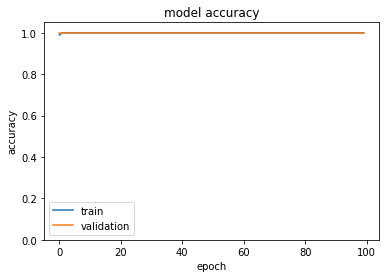

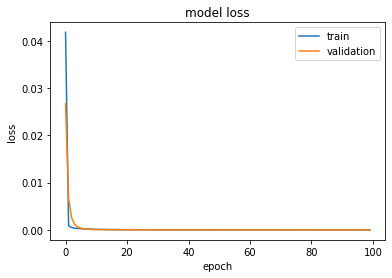

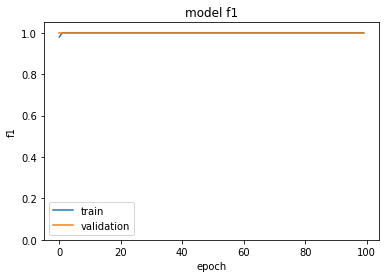

Data Loading...
Data Preprocessing...
X_train_normal shape : (1574, 24, 9)
X_test_normal shape : (394, 24, 9)
X_train_error shape : (1446, 24, 9)
X_test_error shape : (362, 24, 9)
X_train_portent shape : (109, 24, 9)
X_test_portetn shape : (28, 24, 9)
syn portetn shape (with TimeGAN) : (416, 24, 9)
train data shape : (3545, 24, 9)
Data Modeling...
Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9408 - get_f1: 0.9426

28/28 [==============================] - 16s 379ms/step - loss: 0.1589 - accuracy: 0.9408 - get_f1: 0.9426 - val_loss: 0.4421 - val_accuracy: 0.9260 - val_get_f1: 0.8986
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9698 - get_f1: 0.9697

28/28 [==============================] - 9s 335ms/step - loss: 0.1009 - accuracy: 0.9698 - get_f1: 0.9697 - val_loss: 0.2119 - val_accuracy: 0.9719 - val_get_f1: 0.9754
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.9794 - get_f1: 0.9796

28/28 [==============================] - 8s 304ms/step - loss: 0.0644 - accuracy: 0.9794 - get_f1: 0.9796 - val_loss: 0.1247 - val_accuracy: 0.9796 - val_get_f1: 0.9815
Epoch 4/100
28/28 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9870 - get_f1: 0.9872

28/28 [==============================] - 9s 331ms/step - loss: 0.0397 - accuracy: 0.9870 - get_f1: 0.9872 - val_loss: 0.0801 - val_accuracy: 0.9656 - val_get_f1: 0.9703
Epoch 5/100
25/28 [=========================>....] - ETA: 0s - loss: 0.0245 - accuracy: 0.9934 - get_f1: 0.9936

28/28 [==============================] - 9s 331ms/step - loss: 0.0245 - accuracy: 0.9929 - get_f1: 0.9932 - val_loss: 0.0554 - val_accuracy: 0.9923 - val_get_f1: 0.9933
Epoch 6/100
27/28 [===========================>..] - ETA: 0s - loss: 0.0105 - accuracy: 0.9983 - get_f1: 0.9983

28/28 [==============================] - 9s 351ms/step - loss: 0.0103 - accuracy: 0.9983 - get_f1: 0.9983 - val_loss: 0.0525 - val_accuracy: 0.9668 - val_get_f1: 0.9710
Epoch 7/100
28/28 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9994 - get_f1: 0.9994

28/28 [==============================] - 10s 356ms/step - loss: 0.0040 - accuracy: 0.9994 - get_f1: 0.9994 - val_loss: 0.0163 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 8/100
28/28 [==============================] - 1s 18ms/step - loss: 0.0057 - accuracy: 0.9994 - get_f1: 0.9994 - val_loss: 0.0383 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 9/100
25/28 [=========================>....] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 326ms/step - loss: 0.0021 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 10/100
28/28 [==============================] - 0s 17ms/step - loss: 0.0016 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.9394 - val_accuracy: 0.6301 - val_get_f1: 0.5748
Epoch 11/100
28/28 [==============================] - 0s 17ms/step - loss: 0.0016 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.0087 - val_accuracy: 0.9974 - val_get_f1: 0.9978
Epoch 12/100
25/28 [=========================>....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 324ms/step - loss: 0.0011 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 13/100
28/28 [==============================] - 0s 17ms/step - loss: 4.9625e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.0037 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 14/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0012 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 15/100
25/28 [=========================>....] - ETA: 0s - loss: 9.6832e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 326ms/step - loss: 9.0102e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 16/100
28/28 [==============================] - ETA: 0s - loss: 4.6253e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 327ms/step - loss: 4.6253e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.9337e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 17/100
27/28 [===========================>..] - ETA: 0s - loss: 2.7474e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 326ms/step - loss: 2.7123e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.3773e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 18/100
28/28 [==============================] - 1s 18ms/step - loss: 2.9754e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.1289e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 19/100
25/28 [=========================>....] - ETA: 0s - loss: 2.1990e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 10s 363ms/step - loss: 2.1413e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.5109e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 20/100
28/28 [==============================] - 0s 17ms/step - loss: 2.7073e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.7866e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 21/100
28/28 [==============================] - 0s 15ms/step - loss: 1.6013e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.6764e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 22/100
28/28 [==============================] - 0s 16ms/step - loss: 1.4705e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.6369e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 23/100
25/28 [=========================>....] - ETA: 0s - loss: 1.2255e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 330ms/step - loss: 1.2101e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.0590e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 24/100
28/28 [==============================] - ETA: 0s - loss: 1.0658e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 329ms/step - loss: 1.0658e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 9.5825e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 25/100
25/28 [=========================>....] - ETA: 0s - loss: 9.7588e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 328ms/step - loss: 1.0000e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.7022e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 26/100
28/28 [==============================] - 0s 17ms/step - loss: 1.2240e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.9124e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 27/100
25/28 [=========================>....] - ETA: 0s - loss: 8.3200e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 324ms/step - loss: 8.8558e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.1552e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 28/100
27/28 [===========================>..] - ETA: 0s - loss: 7.9778e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 328ms/step - loss: 8.0277e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.6898e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 29/100
28/28 [==============================] - ETA: 0s - loss: 7.4311e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 10s 369ms/step - loss: 7.4311e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.6450e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 30/100
27/28 [===========================>..] - ETA: 0s - loss: 7.4788e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 332ms/step - loss: 7.6216e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.5992e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 31/100
28/28 [==============================] - 0s 17ms/step - loss: 1.0478e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.7081e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 32/100
25/28 [=========================>....] - ETA: 0s - loss: 7.1856e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 331ms/step - loss: 6.9023e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.7064e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 33/100
28/28 [==============================] - 0s 17ms/step - loss: 6.3011e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.4479e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 34/100
28/28 [==============================] - 1s 22ms/step - loss: 6.1919e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.0717e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 35/100
28/28 [==============================] - 1s 25ms/step - loss: 5.4045e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.9550e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 36/100
28/28 [==============================] - 1s 25ms/step - loss: 5.3936e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.9520e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 37/100
28/28 [==============================] - 1s 28ms/step 

28/28 [==============================] - 9s 320ms/step - loss: 6.4145e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.0825e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 39/100
28/28 [==============================] - ETA: 0s - loss: 7.5238e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 339ms/step - loss: 7.5238e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.7242e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 40/100
28/28 [==============================] - 0s 17ms/step - loss: 4.8516e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.9560e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 41/100
25/28 [=========================>....] - ETA: 0s - loss: 5.0323e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 326ms/step - loss: 5.0120e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.3283e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 42/100
28/28 [==============================] - 1s 18ms/step - loss: 5.7271e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.8039e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 43/100
28/28 [==============================] - 0s 17ms/step - loss: 8.8877e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.0068e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 44/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0205 - accuracy: 0.9935 - get_f1: 0.9936 - val_loss: 7.3259 - val_accuracy: 0.5383 - val_get_f1: 0.4710
Epoch 45/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0113 - accuracy: 0.9963 - get_f1: 0.9964 - val_loss: 0.2717 - val_accuracy: 0.8890 - val_get_f1: 0.8638
Epoch 46/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0023 -

28/28 [==============================] - 9s 315ms/step - loss: 3.4246e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.9980e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 65/100
27/28 [===========================>..] - ETA: 0s - loss: 3.2399e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 309ms/step - loss: 3.2618e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.7060e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 66/100
28/28 [==============================] - ETA: 0s - loss: 2.7795e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 336ms/step - loss: 2.7795e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.5975e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 67/100
27/28 [===========================>..] - ETA: 0s - loss: 3.6179e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 326ms/step - loss: 3.5566e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.5326e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 68/100
25/28 [=========================>....] - ETA: 0s - loss: 3.6049e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 327ms/step - loss: 3.8280e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.3849e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 69/100
25/28 [=========================>....] - ETA: 0s - loss: 2.7951e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 10s 361ms/step - loss: 2.7447e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.3227e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 70/100
26/28 [==========================>...] - ETA: 0s - loss: 2.1593e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 347ms/step - loss: 2.1037e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.2277e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 71/100
28/28 [==============================] - 1s 18ms/step - loss: 1.8275e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.3368e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 72/100
25/28 [=========================>....] - ETA: 0s - loss: 1.9765e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 328ms/step - loss: 2.0278e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.1499e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 73/100
28/28 [==============================] - ETA: 0s - loss: 1.9083e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 328ms/step - loss: 1.9083e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.0371e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 74/100
28/28 [==============================] - ETA: 0s - loss: 2.1981e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 326ms/step - loss: 2.1981e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 9.7924e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 75/100
28/28 [==============================] - ETA: 0s - loss: 1.9154e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 327ms/step - loss: 1.9154e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 9.3851e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 76/100
28/28 [==============================] - 0s 17ms/step - loss: 1.7700e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 9.5460e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 77/100
28/28 [==============================] - ETA: 0s - loss: 1.4492e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 333ms/step - loss: 1.4492e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 8.7355e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 78/100
28/28 [==============================] - 1s 29ms/step - loss: 2.4167e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 9.9878e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 79/100
28/28 [==============================] - ETA: 0s - loss: 1.4675e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 10s 367ms/step - loss: 1.4675e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 8.4447e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 80/100
27/28 [===========================>..] - ETA: 0s - loss: 1.3181e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 312ms/step - loss: 1.4756e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.2133e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 81/100
28/28 [==============================] - ETA: 0s - loss: 1.4928e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 344ms/step - loss: 1.4928e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.0481e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 82/100
28/28 [==============================] - 0s 17ms/step - loss: 1.9302e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.0187e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 83/100
28/28 [==============================] - 0s 16ms/step - loss: 2.0350e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 8.1233e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 84/100
25/28 [=========================>....] - ETA: 0s - loss: 1.2159e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 327ms/step - loss: 1.3246e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.3619e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 85/100
28/28 [==============================] - ETA: 0s - loss: 1.5081e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 330ms/step - loss: 1.5081e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.3095e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 86/100
28/28 [==============================] - 0s 17ms/step - loss: 1.1122e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.4497e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 87/100
25/28 [=========================>....] - ETA: 0s - loss: 9.9979e-06 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 324ms/step - loss: 1.0183e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.7960e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 88/100
27/28 [===========================>..] - ETA: 0s - loss: 1.1195e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 10s 366ms/step - loss: 1.1094e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.7780e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 89/100
28/28 [==============================] - 0s 17ms/step - loss: 1.4731e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.7813e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 90/100
25/28 [=========================>....] - ETA: 0s - loss: 1.1689e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 325ms/step - loss: 1.1725e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.4020e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 91/100
28/28 [==============================] - 0s 18ms/step - loss: 1.7510e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 8.1602e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 92/100
24/28 [========================>.....] - ETA: 0s - loss: 1.2953e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 344ms/step - loss: 1.2640e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.1612e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 93/100
27/28 [===========================>..] - ETA: 0s - loss: 8.1267e-06 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 10s 353ms/step - loss: 8.1147e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.9098e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 94/100
28/28 [==============================] - 1s 19ms/step - loss: 1.5676e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.4034e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 95/100
28/28 [==============================] - 0s 16ms/step - loss: 1.1430e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.8579e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 96/100
25/28 [=========================>....] - ETA: 0s - loss: 8.5712e-06 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 327ms/step - loss: 8.9159e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.3105e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 97/100
28/28 [==============================] - 0s 17ms/step - loss: 9.6803e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.4579e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 98/100
28/28 [==============================] - 0s 16ms/step - loss: 8.7656e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.4842e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 99/100
25/28 [=========================>....] - ETA: 0s - loss: 8.4020e-06 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 331ms/step - loss: 8.1540e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.7655e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 100/100
28/28 [==============================] - ETA: 0s - loss: 9.2630e-06 - accuracy: 1.0000 - get_f1: 1.0000

25/25 [==============================] - 1s 5ms/step
<built-in function iter>
Accuracy of the model on test set: 100.0
f1 score of the model on test set: 1.0
[[394   0   0]
 [  0  28   0]
 [  0   0 362]]




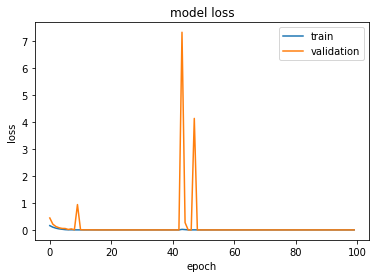

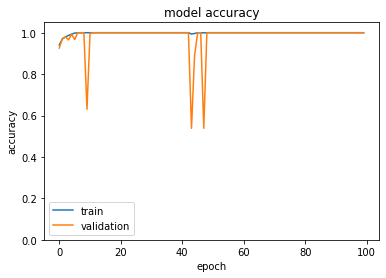

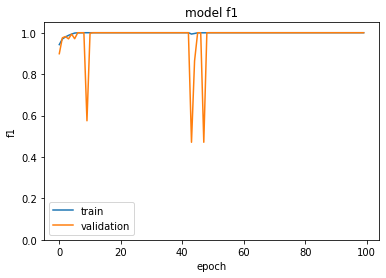

Data Loading...
Data Preprocessing...
X_train_normal shape : (1574, 24, 9)
X_test_normal shape : (394, 24, 9)
X_train_error shape : (1446, 24, 9)
X_test_error shape : (362, 24, 9)
X_train_portent shape : (109, 24, 9)
X_test_portetn shape : (28, 24, 9)
syn portetn shape (with TimeGAN) : (416, 24, 9)
train data shape : (3545, 24, 9)
Data Modeling...
Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9738 - get_f1: 0.9738

28/28 [==============================] - 15s 375ms/step - loss: 0.0998 - accuracy: 0.9738 - get_f1: 0.9738 - val_loss: 0.1052 - val_accuracy: 0.9821 - val_get_f1: 0.9844
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9966 - get_f1: 0.9967

28/28 [==============================] - 8s 310ms/step - loss: 0.0126 - accuracy: 0.9966 - get_f1: 0.9967 - val_loss: 0.0222 - val_accuracy: 0.9974 - val_get_f1: 0.9978
Epoch 3/100
27/28 [===========================>..] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 335ms/step - loss: 0.0020 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.0123 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 4/100
28/28 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 329ms/step - loss: 0.0012 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.0065 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 5/100
28/28 [==============================] - ETA: 0s - loss: 7.3663e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 327ms/step - loss: 7.3663e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 6/100
28/28 [==============================] - ETA: 0s - loss: 6.4306e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 10s 370ms/step - loss: 6.4306e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 7/100
28/28 [==============================] - ETA: 0s - loss: 4.7144e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 308ms/step - loss: 4.7144e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 8/100
27/28 [===========================>..] - ETA: 0s - loss: 4.6810e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 339ms/step - loss: 4.7134e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.1895e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 9/100
27/28 [===========================>..] - ETA: 0s - loss: 3.8532e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 328ms/step - loss: 3.8021e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.9504e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 10/100
25/28 [=========================>....] - ETA: 0s - loss: 4.2073e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 333ms/step - loss: 4.0452e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.8196e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 11/100
27/28 [===========================>..] - ETA: 0s - loss: 3.3811e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 309ms/step - loss: 3.3482e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.8643e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 12/100
27/28 [===========================>..] - ETA: 0s - loss: 3.1050e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 340ms/step - loss: 3.0624e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.3442e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 13/100
26/28 [==========================>...] - ETA: 0s - loss: 2.7971e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 330ms/step - loss: 2.7525e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.7693e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 14/100
28/28 [==============================] - 1s 18ms/step - loss: 2.7180e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.3944e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 15/100
28/28 [==============================] - 0s 16ms/step - loss: 1.9824e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.7285e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 16/100
25/28 [=========================>....] - ETA: 0s - loss: 1.8359e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 328ms/step - loss: 1.8634e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.6545e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 17/100
25/28 [=========================>....] - ETA: 0s - loss: 1.9298e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 11s 420ms/step - loss: 1.8597e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.1743e-04 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 18/100
28/28 [==============================] - ETA: 0s - loss: 1.6882e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 333ms/step - loss: 1.6882e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 9.9715e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 19/100
28/28 [==============================] - ETA: 0s - loss: 1.6254e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 307ms/step - loss: 1.6254e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.4241e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 20/100
27/28 [===========================>..] - ETA: 0s - loss: 1.2247e-04 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 338ms/step - loss: 1.2105e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.9912e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 21/100
28/28 [==============================] - 1s 19ms/step - loss: 1.4202e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.0220e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 22/100
28/28 [==============================] - 1s 18ms/step - loss: 1.6485e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 9.5183e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 23/100
28/28 [==============================] - 0s 16ms/step - loss: 1.0927e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 8.8174e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 24/100
28/28 [==============================] - 0s 15ms/step - loss: 4.1989e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.1892 - val_accuracy: 0.5383 - val_get_f1: 0.4710
Epoch 25/100
28/28 [==============================] - 0s 16ms/step - lo

28/28 [==============================] - 9s 331ms/step - loss: 1.0171e-04 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.3774e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 29/100
25/28 [=========================>....] - ETA: 0s - loss: 7.2475e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 335ms/step - loss: 7.1781e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.1084e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 30/100
27/28 [===========================>..] - ETA: 0s - loss: 8.0032e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 348ms/step - loss: 7.9238e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.4788e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 31/100
27/28 [===========================>..] - ETA: 0s - loss: 6.9653e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 340ms/step - loss: 6.9251e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.4006e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 32/100
25/28 [=========================>....] - ETA: 0s - loss: 7.4956e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 327ms/step - loss: 7.6082e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.7751e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 33/100
25/28 [=========================>....] - ETA: 0s - loss: 5.5780e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 331ms/step - loss: 5.9449e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.4374e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 34/100
25/28 [=========================>....] - ETA: 0s - loss: 5.5670e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 330ms/step - loss: 5.8033e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.1629e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 35/100
27/28 [===========================>..] - ETA: 0s - loss: 5.6844e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 308ms/step - loss: 5.6779e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 3.0170e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 36/100
28/28 [==============================] - ETA: 0s - loss: 8.3404e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 347ms/step - loss: 8.3404e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.4806e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 37/100
28/28 [==============================] - ETA: 0s - loss: 5.0602e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 10s 368ms/step - loss: 5.0602e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.2789e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 38/100
28/28 [==============================] - 1s 18ms/step - loss: 4.9453e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.3455e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 39/100
28/28 [==============================] - 0s 17ms/step - loss: 5.2687e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.3368e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 40/100
28/28 [==============================] - 0s 16ms/step - loss: 5.1875e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.3464e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 41/100
28/28 [==============================] - 0s 16ms/step - loss: 4.9465e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.3274e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 42/100
25/28 [=========================>....] - ETA: 0s - lo

28/28 [==============================] - 9s 329ms/step - loss: 3.9566e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.2113e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 43/100
28/28 [==============================] - ETA: 0s - loss: 4.0145e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 305ms/step - loss: 4.0145e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.1426e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 44/100
28/28 [==============================] - ETA: 0s - loss: 3.6801e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 342ms/step - loss: 3.6801e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 2.0104e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 45/100
28/28 [==============================] - ETA: 0s - loss: 4.3062e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 326ms/step - loss: 4.3062e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.9013e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 46/100
25/28 [=========================>....] - ETA: 0s - loss: 3.7651e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 334ms/step - loss: 3.6366e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.7713e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 47/100
26/28 [==========================>...] - ETA: 0s - loss: 3.1295e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 10s 378ms/step - loss: 3.1295e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.7294e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 48/100
25/28 [=========================>....] - ETA: 0s - loss: 2.7793e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 332ms/step - loss: 2.8884e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.6978e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 49/100
27/28 [===========================>..] - ETA: 0s - loss: 3.1239e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 307ms/step - loss: 3.4119e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.6064e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 50/100
26/28 [==========================>...] - ETA: 0s - loss: 3.3127e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 340ms/step - loss: 3.2659e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.5632e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 51/100
27/28 [===========================>..] - ETA: 0s - loss: 2.8094e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 327ms/step - loss: 2.7877e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.5559e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 52/100
26/28 [==========================>...] - ETA: 0s - loss: 3.1671e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 330ms/step - loss: 3.0755e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.4919e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 53/100
27/28 [===========================>..] - ETA: 0s - loss: 2.6414e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 11s 408ms/step - loss: 2.6629e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.4571e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 54/100
25/28 [=========================>....] - ETA: 0s - loss: 2.7079e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 329ms/step - loss: 2.7316e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.3936e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 55/100
26/28 [==========================>...] - ETA: 0s - loss: 2.8992e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 309ms/step - loss: 2.9436e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.3288e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 56/100
26/28 [==========================>...] - ETA: 0s - loss: 2.8733e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 337ms/step - loss: 2.8157e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.3131e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 57/100
26/28 [==========================>...] - ETA: 0s - loss: 2.3098e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 331ms/step - loss: 2.2546e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.2797e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 58/100
25/28 [=========================>....] - ETA: 0s - loss: 2.5151e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 334ms/step - loss: 2.5631e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.2391e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 59/100
25/28 [=========================>....] - ETA: 0s - loss: 2.0952e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 308ms/step - loss: 2.3625e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.1859e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 60/100
25/28 [=========================>....] - ETA: 0s - loss: 2.8822e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 10s 371ms/step - loss: 2.7731e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.0825e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 61/100
27/28 [===========================>..] - ETA: 0s - loss: 1.9771e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 336ms/step - loss: 1.9730e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.0691e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 62/100
28/28 [==============================] - 1s 18ms/step - loss: 2.2511e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.0707e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 63/100
27/28 [===========================>..] - ETA: 0s - loss: 2.0450e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 328ms/step - loss: 2.0445e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.0511e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 64/100
26/28 [==========================>...] - ETA: 0s - loss: 1.8797e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 328ms/step - loss: 1.9087e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 1.0420e-05 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 65/100
28/28 [==============================] - ETA: 0s - loss: 1.7948e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 309ms/step - loss: 1.7948e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 9.9275e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 66/100
28/28 [==============================] - ETA: 0s - loss: 1.8350e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 337ms/step - loss: 1.8350e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 9.5572e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 67/100
27/28 [===========================>..] - ETA: 0s - loss: 1.8477e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 10s 366ms/step - loss: 1.8371e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 9.2408e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 68/100
28/28 [==============================] - 1s 18ms/step - loss: 2.0363e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 9.6498e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 69/100
28/28 [==============================] - 0s 16ms/step - loss: 1.6349e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 9.4242e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 70/100
25/28 [=========================>....] - ETA: 0s - loss: 1.8934e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 330ms/step - loss: 1.8396e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 8.7752e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 71/100
26/28 [==========================>...] - ETA: 0s - loss: 1.6786e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 309ms/step - loss: 1.7140e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 8.2902e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 72/100
27/28 [===========================>..] - ETA: 0s - loss: 1.5184e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 334ms/step - loss: 1.5238e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 8.1007e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 73/100
28/28 [==============================] - ETA: 0s - loss: 1.6517e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 324ms/step - loss: 1.6517e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.7566e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 74/100
25/28 [=========================>....] - ETA: 0s - loss: 1.3104e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 327ms/step - loss: 1.3184e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.5293e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 75/100
27/28 [===========================>..] - ETA: 0s - loss: 1.1620e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 10s 357ms/step - loss: 1.1740e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.3756e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 76/100
27/28 [===========================>..] - ETA: 0s - loss: 1.6163e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 314ms/step - loss: 1.6171e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.2550e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 77/100
28/28 [==============================] - ETA: 0s - loss: 1.2974e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 336ms/step - loss: 1.2974e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 7.0709e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 78/100
27/28 [===========================>..] - ETA: 0s - loss: 1.3478e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 327ms/step - loss: 1.3510e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.7038e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 79/100
27/28 [===========================>..] - ETA: 0s - loss: 1.4279e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 329ms/step - loss: 1.4490e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.5750e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 80/100
27/28 [===========================>..] - ETA: 0s - loss: 1.4363e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 308ms/step - loss: 1.4204e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.3359e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 81/100
27/28 [===========================>..] - ETA: 0s - loss: 1.2273e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 341ms/step - loss: 1.2816e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 6.3091e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 82/100
26/28 [==========================>...] - ETA: 0s - loss: 1.6622e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 11s 417ms/step - loss: 1.6275e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.9848e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 83/100
27/28 [===========================>..] - ETA: 0s - loss: 1.0669e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 326ms/step - loss: 1.0534e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.9147e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 84/100
28/28 [==============================] - ETA: 0s - loss: 1.1721e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 327ms/step - loss: 1.1721e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.7553e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 85/100
26/28 [==========================>...] - ETA: 0s - loss: 1.1417e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 304ms/step - loss: 1.1431e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.5916e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 86/100
28/28 [==============================] - ETA: 0s - loss: 1.0757e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 336ms/step - loss: 1.0757e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.4800e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 87/100
27/28 [===========================>..] - ETA: 0s - loss: 1.1080e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 329ms/step - loss: 1.0954e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.2715e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 88/100
27/28 [===========================>..] - ETA: 0s - loss: 1.1176e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 10s 361ms/step - loss: 1.1529e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.1909e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 89/100
25/28 [=========================>....] - ETA: 0s - loss: 1.2597e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 309ms/step - loss: 1.2563e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 5.1135e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 90/100
25/28 [=========================>....] - ETA: 0s - loss: 9.7880e-06 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 335ms/step - loss: 1.0799e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.9796e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 91/100
28/28 [==============================] - ETA: 0s - loss: 9.7470e-06 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 322ms/step - loss: 9.7470e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.7918e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 92/100
28/28 [==============================] - ETA: 0s - loss: 1.1433e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 329ms/step - loss: 1.1433e-05 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.6581e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 93/100
27/28 [===========================>..] - ETA: 0s - loss: 1.0036e-05 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 328ms/step - loss: 9.9245e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.6090e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 94/100
28/28 [==============================] - ETA: 0s - loss: 8.1794e-06 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 345ms/step - loss: 8.1794e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.5429e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 95/100
27/28 [===========================>..] - ETA: 0s - loss: 8.9284e-06 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 325ms/step - loss: 8.8153e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.4170e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 96/100
28/28 [==============================] - ETA: 0s - loss: 7.6769e-06 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 337ms/step - loss: 7.6769e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.3884e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 97/100
26/28 [==========================>...] - ETA: 0s - loss: 6.8061e-06 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 331ms/step - loss: 8.6585e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.3426e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 98/100
25/28 [=========================>....] - ETA: 0s - loss: 8.6036e-06 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 9s 333ms/step - loss: 8.5724e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.2771e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 99/100
26/28 [==========================>...] - ETA: 0s - loss: 9.5900e-06 - accuracy: 1.0000 - get_f1: 1.0000

28/28 [==============================] - 8s 311ms/step - loss: 9.3060e-06 - accuracy: 1.0000 - get_f1: 1.0000 - val_loss: 4.0793e-06 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 100/100
27/28 [===========================>..] - ETA: 0s - loss: 7.8974e-06 - accuracy: 1.0000 - get_f1: 1.0000

25/25 [==============================] - 1s 5ms/step
<built-in function iter>
Accuracy of the model on test set: 100.0
f1 score of the model on test set: 1.0
[[394   0   0]
 [  0  28   0]
 [  0   0 362]]




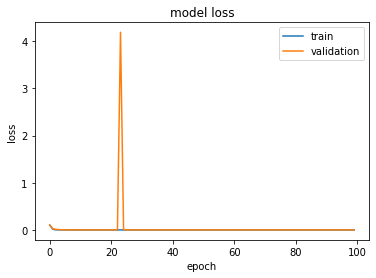

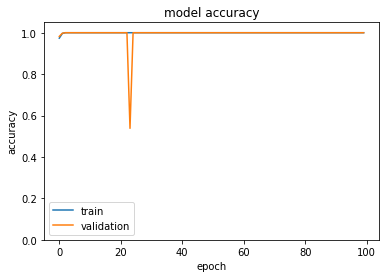

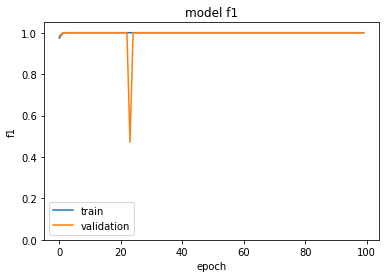

In [ ]:
model,scaler=clf_nor_err_modeling('/content/drive/MyDrive/IPM 모터 고장 실험(상개방, interturn short)데이터_2000RPM_1ms.xlsx') #모델, 스케일러 생성

syn_data_loc='/content/drive/MyDrive/time_gan/experiment_00/'
model_p,scaler_p=clf_por_err_modeling('/content/drive/MyDrive/IPM 모터 고장 실험(상개방, interturn short)데이터_2000RPM_1ms.xlsx',syn_data_loc,error_type='p') #error_p 모델, 스케일러 생성
model_i,scaler_i=clf_por_err_modeling('/content/drive/MyDrive/IPM 모터 고장 실험(상개방, interturn short)데이터_2000RPM_1ms.xlsx',syn_data_loc,error_type='i') #error_i 모델, 스케일러 생성

In [ ]:
#interturn 고장 있는 것 확인 후 정상, 전조증상, 고장 plot check
aug_list=[norm_aug,p_aug,i_aug]
aug_path=[norm_path,p_path,i_path]
i=0 #0(정상만 증강),1(p고장 증강),2(i고장 증강) 중에 선택
for aug in aug_list[i]: #증강한 모든 데이터에 대해서 try
  print(aug)
  test=pd.read_csv(aug_path[i]+aug,index_col=0)
  test_data=test.drop(['target'],axis=1)
  output=test[['target']]
  probs,labels=clf_apply(model,scaler,test_data,output)
  mode=return_mode1(probs)
  if mode=='n': #정상이면 넘어가기
    continue
  #model2,scaler2=clf_pro_err_modeling('/content/drive/MyDrive/IPM 모터 고장 실험(상개방, interturn short)데이터_2000RPM_1ms.xlsx',syn_data_loc,error_type=mode) #n이 아니라면 모델링 시작 # 위 cell에서 이미 모델, 스케일러 생성하여 주석처리함
  elif mode=='p':
    probs,labels=clf_apply(model_p,scaler_p,test_data,output)
  elif mode=='i':
    probs,labels=clf_apply(model_i,scaler_i,test_data,output)
  print(mode)
  plot_por_err_result(probs,labels)

Add_noise_normal.csv
62/62 [==============================] - 0s 5ms/step
Convolve_normal.csv
62/62 [==============================] - 0s 5ms/step
Drift_normal.csv
62/62 [==============================] - 0s 4ms/step
TimeWarp_normal.csv
62/62 [==============================] - 0s 5ms/step
Reverse_normal.csv
62/62 [==============================] - 0s 5ms/step
Resize_normal.csv
94/94 [==============================] - 0s 5ms/step


Add_noise_mix_p.csv
62/62 [==============================] - 1s 8ms/step
p


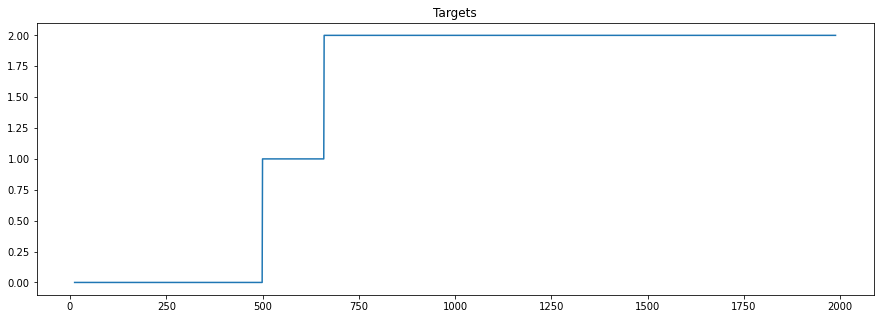

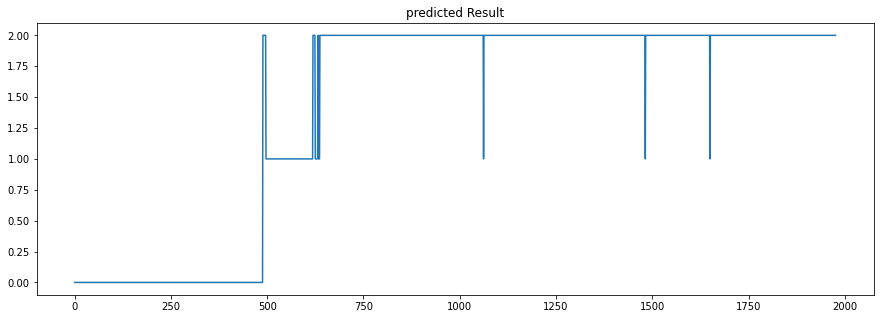

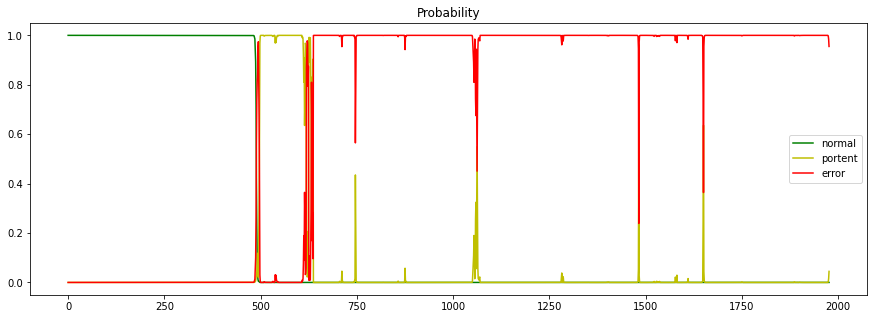

Accuracy : 0.9843196762771876
Drift_mix_p.csv
62/62 [==============================] - 0s 5ms/step
p


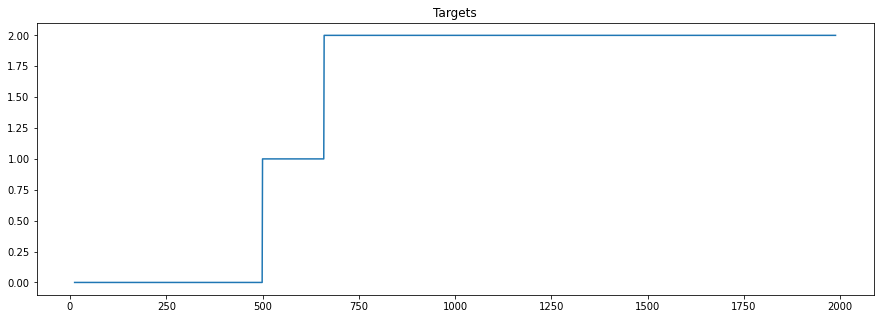

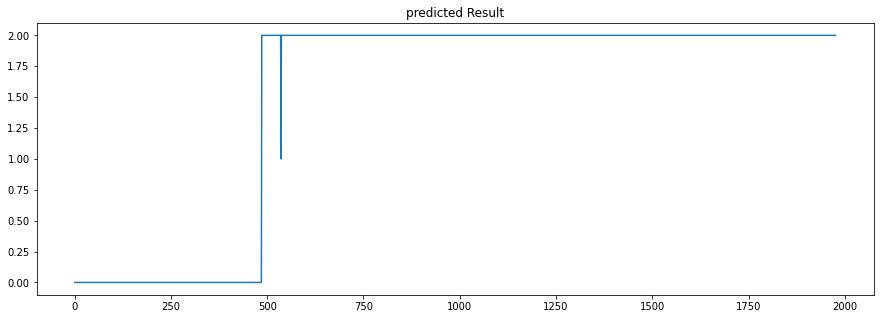

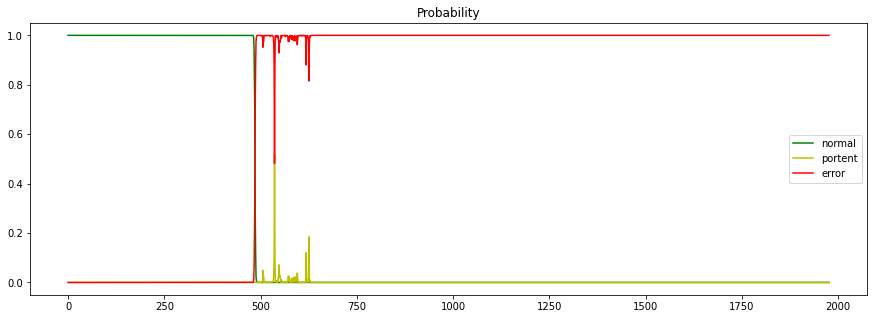

Accuracy : 0.9185634800202327
TimeWarp_mix_p.csv
62/62 [==============================] - 0s 5ms/step
p


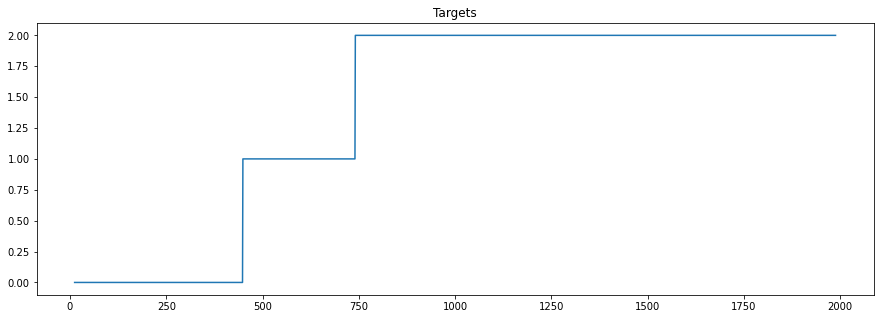

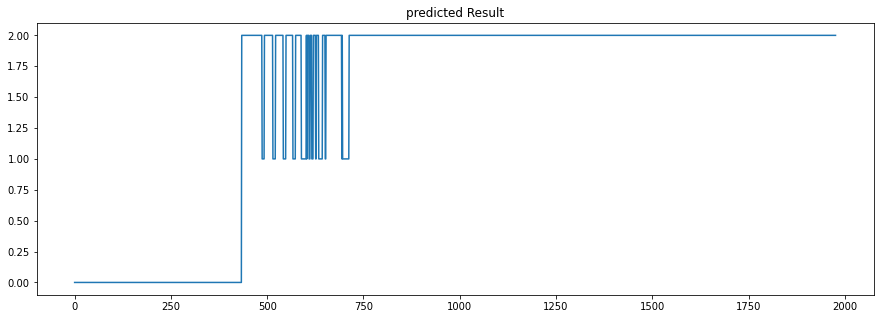

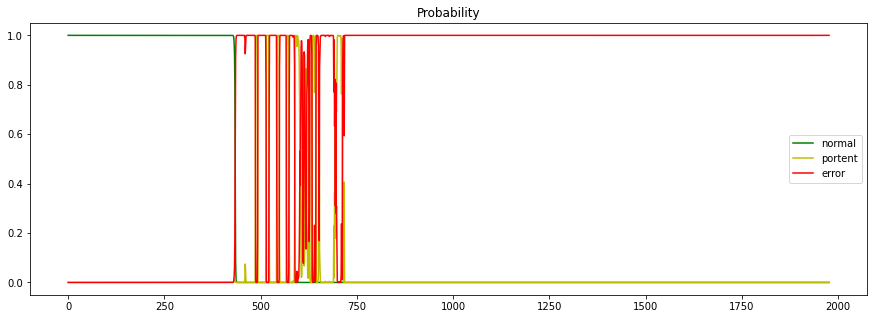

Accuracy : 0.8912493677288822


In [ ]:
i=1 #0(정상만 증강),1(p고장 증강),2(i고장 증강) 중에 선택
for aug in aug_list[i]: #증강한 모든 데이터에 대해서 try
  print(aug)
  test=pd.read_csv(aug_path[i]+aug,index_col=0)
  test_data=test.drop(['target'],axis=1)
  output=test[['target']]
  probs,labels=clf_apply(model,scaler,test_data,output)
  mode=return_mode1(probs)
  if mode=='n': #정상이면 넘어가기
    continue
  #model2,scaler2=clf_pro_err_modeling('/content/drive/MyDrive/IPM 모터 고장 실험(상개방, interturn short)데이터_2000RPM_1ms.xlsx',syn_data_loc,error_type=mode) #n이 아니라면 모델링 시작 # 위 cell에서 이미 모델, 스케일러 생성하여 주석처리함
  elif mode=='p':
    probs,labels=clf_apply(model_p,scaler_p,test_data,output)
  elif mode=='i':
    probs,labels=clf_apply(model_i,scaler_i,test_data,output)
  print(mode)
  plot_por_err_result(probs,labels)

Add_noise_mix_i.csv
62/62 [==============================] - 0s 4ms/step
i


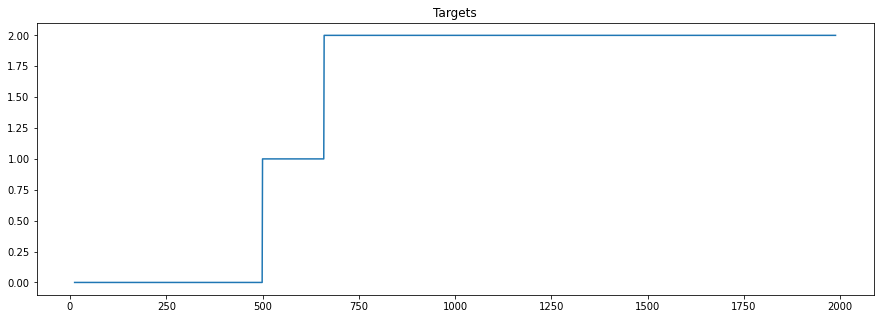

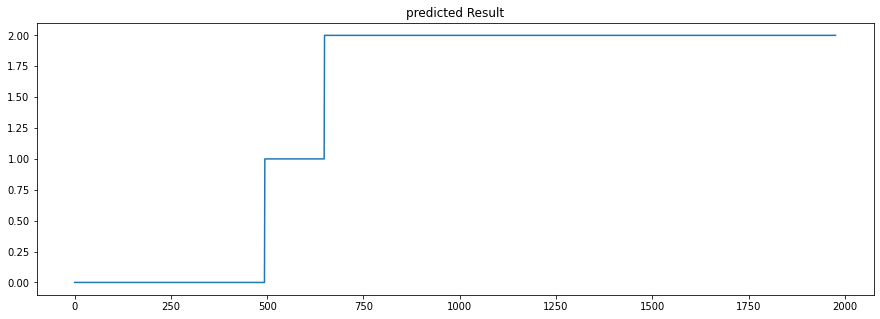

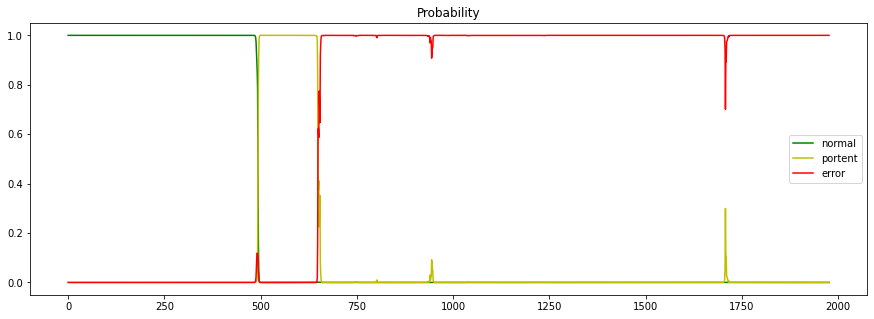

Accuracy : 0.9964592817400101
Convolve_mix_i.csv
62/62 [==============================] - 0s 4ms/step
i


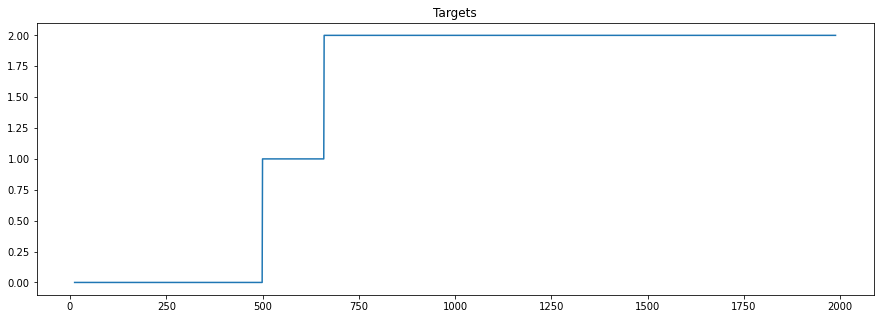

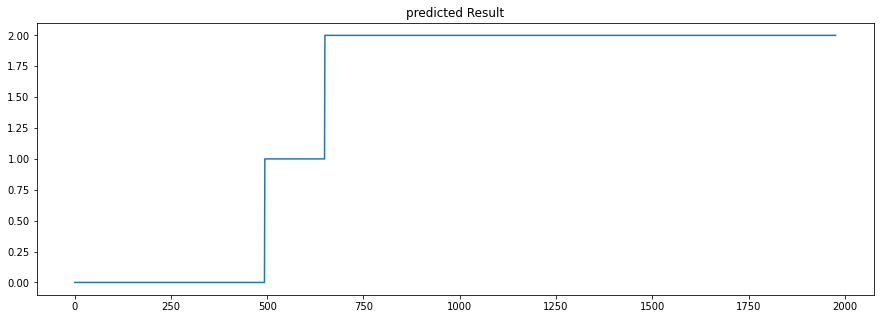

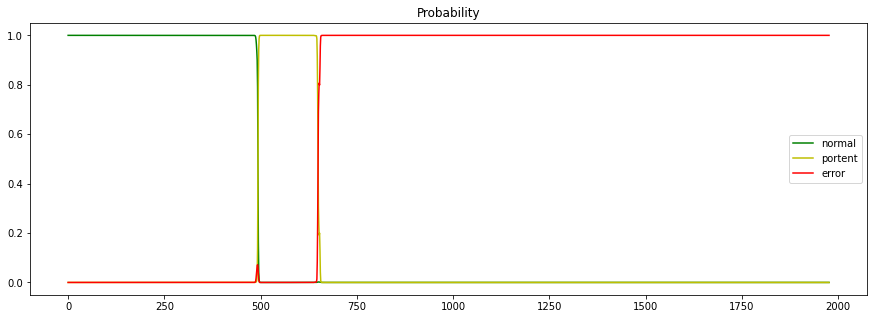

Accuracy : 0.9959534648457259
Drift_mix_i.csv
62/62 [==============================] - 0s 5ms/step
i


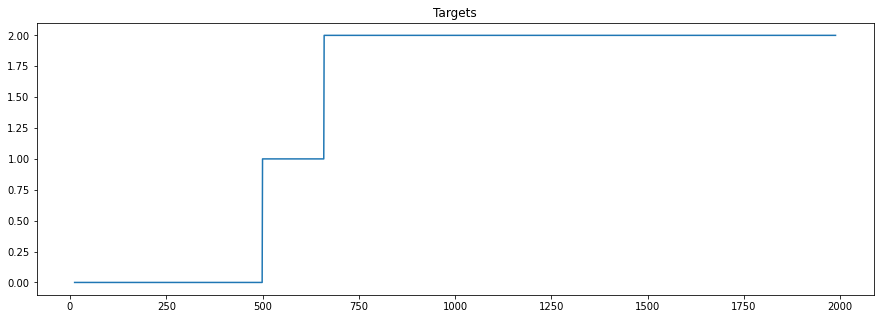

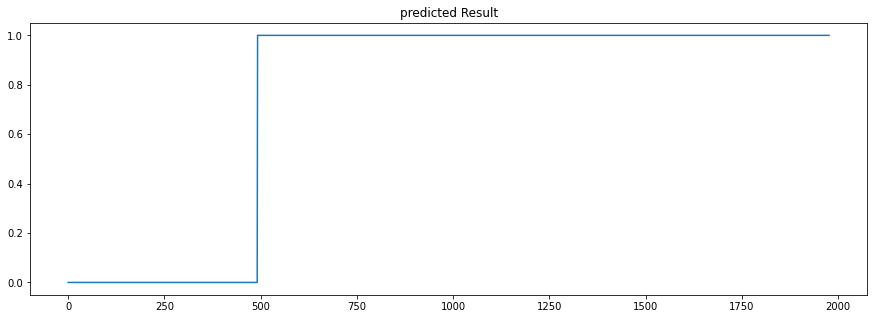

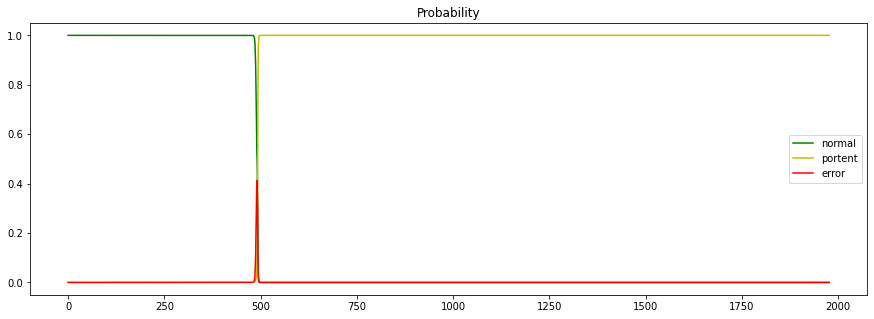

Accuracy : 0.3257460799190693
TimeWarp_mix_i.csv
62/62 [==============================] - 0s 8ms/step
i


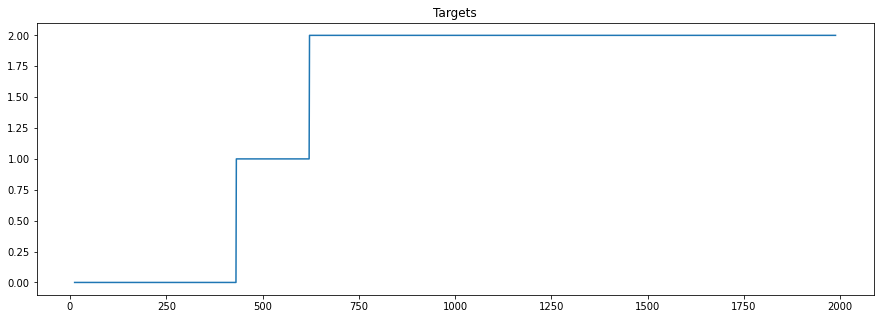

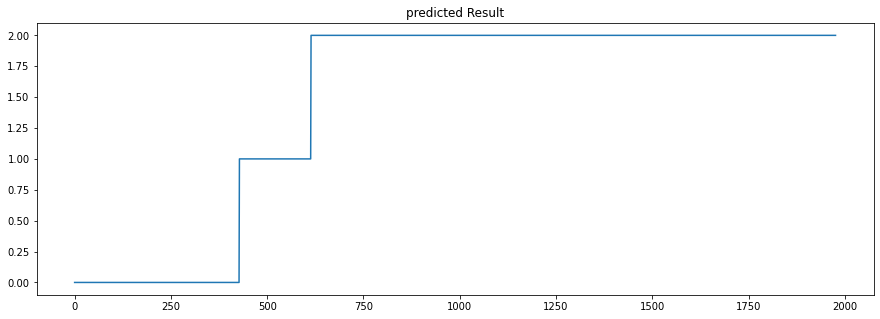

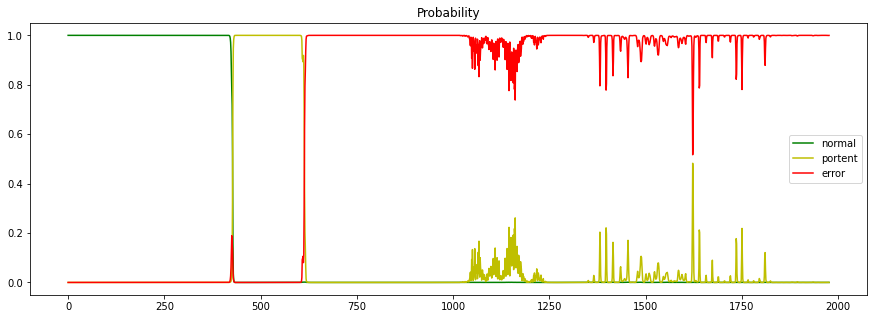

Accuracy : 0.9939301972685888


In [ ]:
i=2 #0(정상만 증강),1(p고장 증강),2(i고장 증강) 중에 선택
for aug in aug_list[i]: #증강한 모든 데이터에 대해서 try
  print(aug)
  test=pd.read_csv(aug_path[i]+aug,index_col=0)
  test_data=test.drop(['target'],axis=1)
  output=test[['target']]
  probs,labels=clf_apply(model,scaler,test_data,output)
  mode=return_mode1(probs)
  if mode=='n': #정상이면 넘어가기
    continue
  #model2,scaler2=clf_pro_err_modeling('/content/drive/MyDrive/IPM 모터 고장 실험(상개방, interturn short)데이터_2000RPM_1ms.xlsx',syn_data_loc,error_type=mode) #n이 아니라면 모델링 시작 # 위 cell에서 이미 모델, 스케일러 생성하여 주석처리함
  elif mode=='p':
    probs,labels=clf_apply(model_p,scaler_p,test_data,output)
  elif mode=='i':
    probs,labels=clf_apply(model_i,scaler_i,test_data,output)
  print(mode)
  plot_por_err_result(probs,labels)